In [1]:
import torch
import pandas as pd
import numpy as np
import os
from loss import KL
from scipy import sparse

# sparse_data = sparse.load_npz('fulldata2.npz').tocsr()[:5000000,:]

In [2]:
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [3]:
class autoencoder(nn.Module):
    def __init__(self, n):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, n), 
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



In [4]:
def train(n, dataloader):
    learning_rate = 1e-5
    num_epochs = 5
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = autoencoder(n)
    model.to(device)
    #print(summary(data.shape[1], model))
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    losses = []
    for epoch in range(num_epochs):
        loss_ = 0
        count = 0
        kl_loss_ = 0
        for data in dataloader:
            img = Variable(data).to(device)
            # ===================forward=====================
            encoded, decoded = model(img)
            loss = criterion(decoded, img) 
            loss_ += loss
            count += 1
                # ===================backward====================
            optimizer.zero_grad()
    #         loss_opt.backward()
            loss.backward()
            optimizer.step()
                # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch+1, num_epochs, loss_/count))
        losses.append(loss_/count)
    return model

In [5]:
data = sparse.load_npz('one.npz').tocsr()

In [6]:
import numpy 
m = 677409
n = 5197
for i in [0.2, 0.4, 0.6, 0.8, 1]:
    print(int(m*i))
    torch_data = torch.from_numpy(data[:int(m*i),:].todense().astype(np.float32))
    batch_size = 128
    dataloader = DataLoader(torch_data, batch_size=batch_size, shuffle=True)
    print('data_loaded')
    model = train(n, dataloader)
    print('trained')
    torch.save(model, 'model_{}'.format(i))
#     encoded_data, _ = model.to('cpu')(data.todense().astype(np.float32))
#     pd.DataFrame(encoded_data.detach().numpy()).to_csv('autoencoder_{}_1.csv'.format(i), index=False)

67740
data_loaded
epoch [1/5], loss:0.4413
epoch [2/5], loss:0.0129
epoch [3/5], loss:0.0099
epoch [4/5], loss:0.0094
epoch [5/5], loss:0.0091
trained


/home/tc2777/miniconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


96772
data_loaded
epoch [1/5], loss:0.3066
epoch [2/5], loss:0.0104
epoch [3/5], loss:0.0093
epoch [4/5], loss:0.0089
epoch [5/5], loss:0.0086
trained
135481
data_loaded
epoch [1/5], loss:0.2280
epoch [2/5], loss:0.0096
epoch [3/5], loss:0.0089
epoch [4/5], loss:0.0086
epoch [5/5], loss:0.0084
trained
225803
data_loaded
epoch [1/5], loss:0.1423
epoch [2/5], loss:0.0089
epoch [3/5], loss:0.0085
epoch [4/5], loss:0.0080
epoch [5/5], loss:0.0068
trained
677409
data_loaded
epoch [1/5], loss:0.0511
epoch [2/5], loss:0.0072
epoch [3/5], loss:0.0062
epoch [4/5], loss:0.0061
epoch [5/5], loss:0.0060
trained


In [5]:
torch_data = torch.from_numpy(sparse.load_npz('one.npz').tocsr().todense().astype(np.float32))
for i in [10, 7, 5, 3, 1]:
    model = torch.load('model_{}'.format(i))
    encoded_data, _ = model.to('cpu')(torch_data)
    pd.DataFrame(encoded_data.detach().numpy()).to_csv('autoencoder_{}_1.csv'.format(i), index=False)

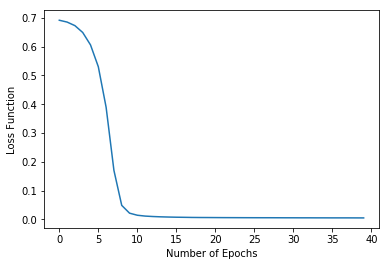

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss Function')
plt.xlabel('Number of Epochs')
plt.show()

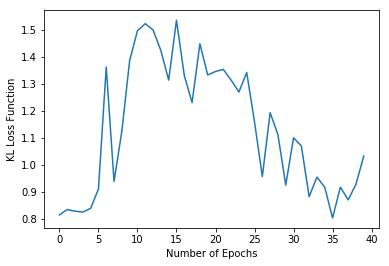

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(kl_losses)
plt.ylabel('KL Loss Function')
plt.xlabel('Number of Epochs')
plt.show()

In [9]:
encoded_data, _ = model.to('cpu')(torch_data.to('cpu'))

In [10]:
pd.DataFrame(encoded_data.detach().numpy()).to_csv('autoencoder_800.csv', index=False)

In [11]:
spark = SparkSession.builder.master("local[*]").appName("Capstone").getOrCreate()
# data = spark.createDataFrame(data)

NameError: name 'SparkSession' is not defined

In [37]:
# create sparse matrix
cols = data.columns
vecAssembler = VectorAssembler(inputCols = cols, outputCol='features')
sparse_matrix = vecAssembler.transform(data).select('features')
# Run Kmeans on the original dataset
bkm = BisectingKMeans(k=5, seed=1)
kmeans = bkm.fit(sparse_matrix)
kmeans_label = kmeans.transform(sparse_matrix)

NameError: name 'VectorAssembler' is not defined

In [ ]:
kmeans_label.toPandas().to_csv('label.csv', index=False)

In [ ]:
data = spark.read.csv('sampled.csv', header=True, inferSchema=True)

In [ ]:
# create sparse matrix
cols = [x for x in data.columns if x != '_c0']
vecAssembler = VectorAssembler(inputCols = cols, outputCol='features')
pca_matrix = vecAssembler.transform(data).select('_c0', 'features').withColumnRenamed('_c0', 'id')

In [ ]:
pca_matrix.show()

In [ ]:
pca = PCA(k=2, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(pca_matrix)

In [ ]:
pca_label = pca_model.transform(pca_matrix)


# Extract PCA Components
def get_pca_component_1(v):
    a = DenseVector(v)
    return float(a[0])

pca1 = udf(get_pca_component_1, FloatType())

def get_pca_component_2(v):
    a = DenseVector(v)
    return float(a[1])

pca2 = udf(get_pca_component_2, FloatType())

pca_label = pca_label.withColumn('pca1', pca1(col('pca_features'))).withColumn('pca2', pca2(col('pca_features'))).select('pca1', 'pca2')


In [ ]:
import pandas as pd

In [ ]:


pca = pd.concat([pd.read_csv('pca.csv'), pd.read_csv('label.csv')['prediction']], axis=1)

In [ ]:
%matplotlib inline
pca.plot.scatter(x='pca1',y='pca2',c='prediction',colormap='viridis')

In [ ]:
data = pd.DataFrame(encoded_data.detach().numpy())

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(data)

In [ ]:
a = pd.DataFrame(X_embedded)
a.columns = ['1', '2']

In [ ]:
tsne = pd.concat([a, pd.read_csv('label.csv')['prediction']], axis=1)

In [ ]:
%matplotlib inline
tsne.plot.scatter(x='1',y='2',c='prediction',colormap='tab10')

In [ ]:
import matplotlib.cm as cmx